In [1]:
import pickle as pkl
import viz_sequence
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import scipy.ndimage
import random

In [2]:
tf_prof = "tf_deepshap/SPI1.dnase.strand0.fold0.deepSHAP"
sig_prof = "all_deepshap/gm12878.dnase.fold0.deepSHAP"
tf_data = pkl.load(open(tf_prof, "rb"))
sig_data = pkl.load(open(sig_prof, "rb"))
histone="dnase_old"

print(np.array(list(tf_data['profile_shap'].values())).shape)

input_length_tf=2114
input_length_sig=71000

(6954, 2114, 4)


In [3]:
#print(list(tf_data['seq'].keys())[0:10])

In [4]:
#tup1 = ('chrX', 9677599)
#act_scores = tf_data['profile_shap'][tup1]*tf_data["seq"][tup1]
#print(act_scores.shape)
#viz_sequence.plot_weights(act_scores[(input_length_tf // 2) - 500:(input_length_tf // 2) + 500], subticks_frequency=100)

In [5]:
#act_scores = tf_data['count_shap'][tup1]*tf_data["seq"][tup1]
#print(act_scores.shape)
#viz_sequence.plot_weights(act_scores[(input_length_tf // 2) - 500:(input_length_tf // 2) + 500], subticks_frequency=100)

In [6]:
#act_scores = sig_data['profile_shap'][tup1]*sig_data["seq"][tup1]
#print(act_scores.shape)
#viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - 500:(input_length_sig // 2) + 500], subticks_frequency=100)

In [7]:
#act_scores = sig_data['count_shap'][tup1]*sig_data["seq"][tup1]
#print(act_scores.shape)
##viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - 500:(input_length_sig // 2) + 500], subticks_frequency=100)

In [8]:
# take aways in plots the range for hist needs to be set
# for jsd and metrics  we should consider the same length input
def compare_profile_similarity_metrics(data_tf, data_sig,type_key, smooth_istrue=False, input_keys=None):
    pearsonr_corr = []
    pearsonr_random = []
    spearmanr_corr = []
    spearmanr_random = []
    jsd_corr = []
    jsd_random = []
    jsd_random1 = []
    keys_list = []
    width=500
    if input_keys==None:
        input_keys=data_tf["seq"]
    for key in input_keys:
        midpoint1=data_tf[type_key][key].shape[0]//2
        midpoint2=data_sig[type_key][key].shape[0]//2
        
        tf_prof = data_tf[type_key][key][midpoint1-width:midpoint1+width]
        sig_prof = data_sig[type_key][key][midpoint2-width:midpoint2+width]
        
        #print(tf_prof.shape)
        #print(sig_prof.shape)
        rnd_reg = random.sample(input_keys, 1)[0]
        while rnd_reg == key:
            rnd_reg = random.sample(input_keys,1)[0]
            
        rnd_sig_prof = data_sig[type_key][rnd_reg][midpoint2-width:midpoint2+width]
        keys_list.append(key)
        if "shap" in type_key:
            tf_prof = tf_prof*data_tf["seq"][key][midpoint1-width:midpoint1+width]
            sig_prof = sig_prof*data_sig["seq"][key][midpoint2-width:midpoint2+width]

            tf_prof = np.sum(tf_prof,axis=1)
            sig_prof = np.sum(sig_prof,axis=1)
            
            tf_prof = np.abs(tf_prof)+1e-10
            sig_prof = np.abs(sig_prof)+1e-10
            
            tf_prof = tf_prof / np.sum(tf_prof)
            sig_prof = sig_prof / np.sum(sig_prof)
            
            rnd_sig_prof = data_sig[type_key][rnd_reg][midpoint2-width:midpoint2+width]*data_sig["seq"][rnd_reg][midpoint2-width:midpoint2+width]
            rnd_sig_prof = np.sum(rnd_sig_prof,axis=1)
            rnd_sig_prof = np.abs(rnd_sig_prof)+1e-10
            rnd_sig_prof = rnd_sig_prof / np.sum(rnd_sig_prof)
        
        if smooth_istrue:
            tf_prof = scipy.ndimage.gaussian_filter1d(tf_prof, 7, truncate=(80 / 14))
            sig_prof = scipy.ndimage.gaussian_filter1d(sig_prof, 7, truncate=(80 / 14))
            rnd_sig_prof = scipy.ndimage.gaussian_filter1d(rnd_sig_prof, 7, truncate=(80 / 14))


        pearsonr_corr.append(pearsonr(tf_prof, sig_prof)[0])
        spearmanr_corr.append(spearmanr(tf_prof, sig_prof)[0])
        jsd_corr.append(jensenshannon(tf_prof, sig_prof, 2.0))

        rnd_sig_prof1 = np.random.permutation(sig_prof)
        pearsonr_random.append(pearsonr(tf_prof, rnd_sig_prof)[0])
        spearmanr_random.append(spearmanr(tf_prof, rnd_sig_prof)[0])
        jsd_random.append(jensenshannon(tf_prof, rnd_sig_prof, 2.0))
        jsd_random1.append(jensenshannon(tf_prof, rnd_sig_prof1, 2.0))
        
    # global metrics
    print(type_key)
    print("mean pearsonr",np.mean(pearsonr_corr), np.std(pearsonr_corr))
    print("random mean pearsonr",np.mean(pearsonr_random), np.std(pearsonr_random))
    print("mean spearmanr",np.mean(spearmanr_corr), np.std(spearmanr_corr))
    print("random mean spearmanr",np.mean(spearmanr_random), np.std(spearmanr_random))
    print("mean jsd",np.mean(jsd_corr), np.std(jsd_corr))
    print("random mean jsd",np.mean(jsd_random), np.std(jsd_random))
    
    print(sum(np.isnan(pearsonr_corr)))
    print(sum(np.isnan(pearsonr_random)))
    print(sum(np.isnan(spearmanr_corr)))
    print(sum(np.isnan(spearmanr_random)))
    print(sum(np.isnan(jsd_corr)))
    print(sum(np.isnan(jsd_random)))

    return pearsonr_corr, pearsonr_random, spearmanr_corr, spearmanr_random, jsd_corr, jsd_random, keys_list
        
input_key_list=tf_data["seq"].keys()       

In [9]:
prof_pearsonr_corr, prof_pearsonr_random, prof_spearmanr_corr, prof_spearmanr_random, prof_jsd_corr, prof_jsd_random, prof_key_list = compare_profile_similarity_metrics(tf_data, sig_data, type_key="label_prof", smooth_istrue=True, input_keys=input_key_list)


label_prof
mean pearsonr 0.45606522464112415 0.244074749493069
random mean pearsonr 0.40631959290958625 0.2646587955265829
mean spearmanr 0.513231006703909 0.1953194946307435
random mean spearmanr 0.3842462355385223 0.24564437761525118
mean jsd 0.5525341980319977 0.09514012443102068
random mean jsd 0.5874936170303178 0.10414379337027017
0
0
0
0
0
0


In [10]:
count_shap_pearsonr_corr, count_shap_pearsonr_random, count_shap_spearmanr_corr, count_shap_spearmanr_random, count_shap_jsd_corr, count_shap_jsd_random, count_shap_key_list = compare_profile_similarity_metrics(tf_data, sig_data, type_key="count_shap",  input_keys=input_key_list,  smooth_istrue=True)

count_shap
mean pearsonr 0.7148035590415504 0.24952541548129448
random mean pearsonr 0.42990672035171046 0.25579316850618644
mean spearmanr 0.54273292678297 0.16297316834749043
random mean spearmanr 0.40211426248009513 0.19884236261451896
mean jsd 0.33722252090513705 0.0865150508252462
random mean jsd 0.4397572818433771 0.0948821578515587
0
0
0
0
0
0


In [11]:
prof_shap_pearsonr_corr, prof_shap_pearsonr_random, prof_shap_spearmanr_corr, prof_shap_spearmanr_random, prof_shap_jsd_corr, prof_shap_jsd_random, prof_shap_key_list = compare_profile_similarity_metrics(tf_data, sig_data, type_key="profile_shap", input_keys=input_key_list, smooth_istrue=True )


profile_shap
mean pearsonr 0.5878525696566312 0.3220767187969623
random mean pearsonr 0.366376640900559 0.29402234878220473
mean spearmanr 0.4515805052250264 0.24419378241747206
random mean spearmanr 0.2674519162888447 0.24990797076840265
mean jsd 0.3509745285409439 0.10352409405164394
random mean jsd 0.41340172190580876 0.08983391101780148
0
0
0
0
0
0


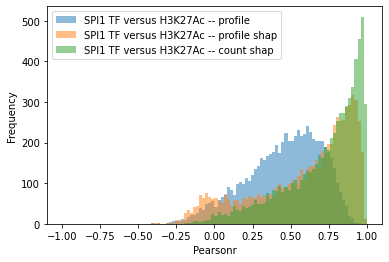

In [12]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_pearsonr_corr, range=(-1,1), bins=100, alpha=0.5, label="SPI1 TF versus H3K27Ac -- profile", density=False, stacked=True)
plt.hist(prof_shap_pearsonr_corr, range=(-1,1), bins=100, alpha=0.5, label="SPI1 TF versus H3K27Ac -- profile shap", density=False,stacked=True)
plt.hist(count_shap_pearsonr_corr, range=(-1,1), bins=100, alpha=0.5, label="SPI1 TF versus H3K27Ac -- count shap", density=False,stacked=True)
plt.legend()
plt.xlabel("Pearsonr")
plt.ylabel("Frequency")
plt.show()


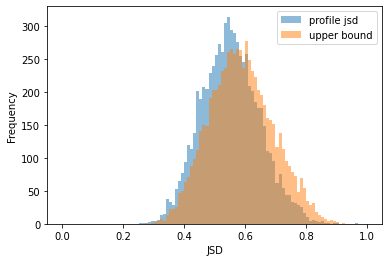

In [13]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_jsd_corr, bins=100, range=(0,1), alpha=0.5, label="profile jsd")
plt.hist(prof_jsd_random, bins=100, range=(0,1), alpha=0.5, label="upper bound")
plt.legend()
plt.xlabel("JSD")
plt.ylabel("Frequency")
plt.show()

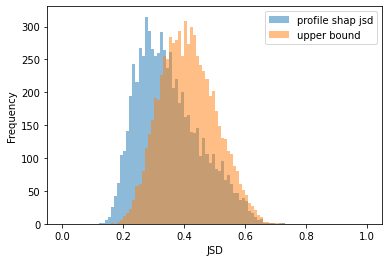

In [14]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_shap_jsd_corr, bins=100, range=(0,1), alpha=0.5, label="profile shap jsd")
plt.hist(prof_shap_jsd_random, bins=100, range=(0,1), alpha=0.5, label="upper bound")
plt.legend()
plt.xlabel("JSD")
plt.ylabel("Frequency")
plt.show()

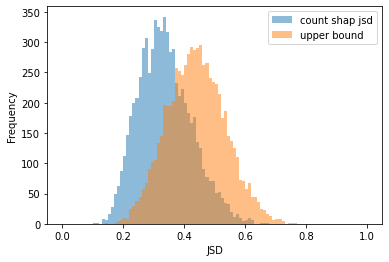

In [15]:
plt.figure()
plt.hist(count_shap_jsd_corr, bins=100, range=(0,1), alpha=0.5, label="count shap jsd")
plt.hist(count_shap_jsd_random, bins=100, range=(0,1), alpha=0.5, label="upper bound")
plt.legend()
plt.xlabel("JSD")
plt.ylabel("Frequency")
plt.show()

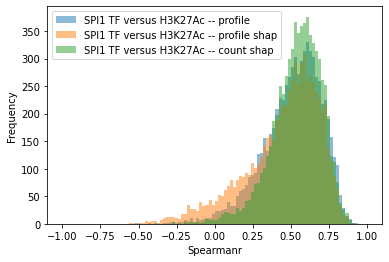

In [16]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_spearmanr_corr, bins=100, range=(-1,1), alpha=0.5, label="SPI1 TF versus H3K27Ac -- profile")
plt.hist(prof_shap_spearmanr_corr, bins=100,range=(-1,1), alpha=0.5, label="SPI1 TF versus H3K27Ac -- profile shap")
plt.hist(count_shap_spearmanr_corr, bins=100, range=(-1,1), alpha=0.5, label="SPI1 TF versus H3K27Ac -- count shap")
plt.legend()
plt.xlabel("Spearmanr")
plt.ylabel("Frequency")
plt.show()

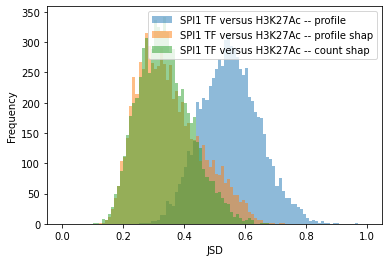

In [17]:
#print(count_shap_jsd_corr)
plt.figure()
plt.hist(prof_jsd_corr, bins=100, range=(0,1), alpha=0.5, label="SPI1 TF versus H3K27Ac -- profile")
plt.hist(prof_shap_jsd_corr, bins=100, range=(0,1), alpha=0.5, label="SPI1 TF versus H3K27Ac -- profile shap")
plt.hist(count_shap_jsd_corr, bins=100, range=(0,1),  alpha=0.5, label="SPI1 TF versus H3K27Ac -- count shap")
plt.legend()
plt.xlabel("JSD")
plt.ylabel("Frequency")
plt.show()

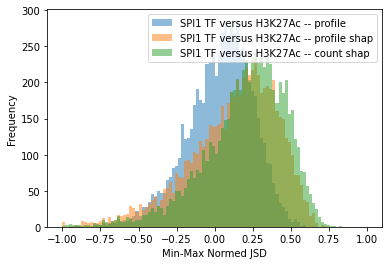

In [18]:
def min_max_norm(metric, min_val):
    normed = []
    for idx in range(len(metric)):
        val = (metric[idx]-min_val[idx])/(0-min_val[idx])
        normed.append(val)
    return normed
    
normed_prof=min_max_norm(prof_jsd_corr,prof_jsd_random)
normed_prof_shap = min_max_norm(prof_shap_jsd_corr,prof_shap_jsd_random)
normed_counr_shap = min_max_norm(count_shap_jsd_corr,count_shap_jsd_random)
plt.figure()
plt.hist(normed_prof, bins=100, range=(-1,1), alpha=0.5, label="SPI1 TF versus H3K27Ac -- profile")
plt.hist(normed_prof_shap, bins=100, range=(-1,1), alpha=0.5, label="SPI1 TF versus H3K27Ac -- profile shap")
plt.hist(normed_counr_shap, bins=100, range=(-1,1),  alpha=0.5, label="SPI1 TF versus H3K27Ac -- count shap")
plt.legend()
plt.xlabel("Min-Max Normed JSD")
plt.ylabel("Frequency")
plt.show()

In [19]:
print("min-max on profile",np.mean(normed_prof),np.std(normed_prof))
print("min-max on profile shap",np.mean(normed_prof_shap),np.std(normed_prof_shap))
print("min-max on count shap",np.mean(normed_counr_shap),np.std(normed_counr_shap))

min-max on profile 0.03482987831249036 0.21704382573476375
min-max on profile shap 0.12042508932212741 0.29628803700375345
min-max on count shap 0.1964619048575415 0.27733499014453267


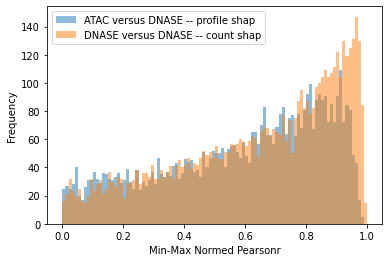

In [20]:
def min_max_norm_corr(metric, min_val):
    normed = []
    for idx in range(len(metric)):
        val = (metric[idx]-min_val[idx])/(1-min_val[idx])
        normed.append(val)
    return normed
    
normed_prof_shap1 = min_max_norm_corr(prof_shap_pearsonr_corr,prof_shap_pearsonr_random)
normed_counr_shap1 = min_max_norm_corr(count_shap_pearsonr_corr,count_shap_pearsonr_random)
plt.figure()
plt.hist(normed_prof_shap1, bins=100, range=(0,1), alpha=0.5, label="ATAC versus DNASE -- profile shap")
plt.hist(normed_counr_shap1, bins=100, range=(0,1),  alpha=0.5, label="DNASE versus DNASE -- count shap")
plt.legend()
plt.xlabel("Min-Max Normed Pearsonr")
plt.ylabel("Frequency")
plt.show()


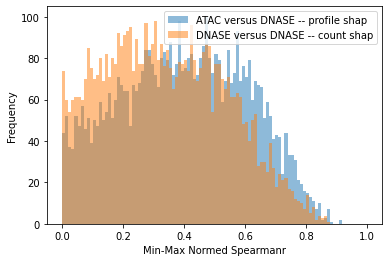

In [21]:
def min_max_norm_corr(metric, min_val):
    normed = []
    for idx in range(len(metric)):
        val = (metric[idx]-min_val[idx])/(1-min_val[idx])
        normed.append(val)
    return normed
    
normed_prof_shap2 = min_max_norm_corr(prof_shap_spearmanr_corr,prof_shap_spearmanr_random)
normed_counr_shap2 = min_max_norm_corr(count_shap_spearmanr_corr,count_shap_spearmanr_random)
plt.figure()
plt.hist(normed_prof_shap2, bins=100, range=(0,1), alpha=0.5, label="ATAC versus DNASE -- profile shap")
plt.hist(normed_counr_shap2, bins=100, range=(0,1),  alpha=0.5, label="DNASE versus DNASE -- count shap")
plt.legend()
plt.xlabel("Min-Max Normed Spearmanr")
plt.ylabel("Frequency")
plt.show()


In [22]:
out_dir="/oak/stanford/groups/akundaje/projects/chrombpnet/anusri_files/spi1_scores/"
import pandas as pd
updatel = list([x[0]+":"+str(x[1]) for x in input_key_list])
header1=["region_id", "NormedJSD", "NormedPearsonr", "NormedSpearmanr", "Pearsonr", "Pearsonr_random", "Spearmanr", "Spearmanr_random", "JSD", "JSD_random"]
datadf = pd.DataFrame(np.array([np.array(updatel), normed_prof_shap, normed_prof_shap1, normed_prof_shap2, prof_shap_pearsonr_corr, prof_shap_pearsonr_random, prof_shap_spearmanr_corr, prof_shap_spearmanr_random, prof_shap_jsd_corr, prof_shap_jsd_random]).transpose(),
                   columns=header1)
datadf.to_csv(out_dir+"/"+histone+"spi1.profile.scores.new.csv",index=False)

In [23]:
header1=["region_id", "NormedJSD",  "NormedPearsonr", "NormedSpearmanr", "Pearsonr", "Pearsonr_random", "Spearmanr", "Spearmanr_random", "JSD", "JSD_random"]
datadf = pd.DataFrame(np.array([np.array(updatel), normed_counr_shap, normed_counr_shap1, normed_counr_shap2, count_shap_pearsonr_corr, count_shap_pearsonr_random, count_shap_spearmanr_corr, count_shap_spearmanr_random, count_shap_jsd_corr, count_shap_jsd_random]).transpose(),
                   columns=header1)
datadf.to_csv(out_dir+"/"+histone+"spi1.count.scores.new.csv",index=False)

In [24]:
header=["NormedJSD", "NormedPearsonr", "NormedSpearmanr", "Pearsonr", "Pearsonr_random", "Spearmanr", "Spearmanr_random", "JSD", "JSD_random"]
prof_metrics = [normed_prof_shap, normed_prof_shap1, normed_prof_shap2, prof_shap_pearsonr_corr, prof_shap_pearsonr_random, prof_shap_spearmanr_corr, prof_shap_spearmanr_random, prof_shap_jsd_corr, prof_shap_jsd_random]
count_metrics = [normed_counr_shap, normed_counr_shap1, normed_counr_shap2, count_shap_pearsonr_corr, count_shap_pearsonr_random, count_shap_spearmanr_corr, count_shap_spearmanr_random, count_shap_jsd_corr, count_shap_jsd_random]

heading = ["Statistic", "Count", "Profile"]
rows=[]
for idx in range(len(header)):
    rows.append([header[idx]+"_mean", np.round(np.mean(prof_metrics[idx]),2), np.round(np.mean(count_metrics[idx]),2)])
    rows.append([header[idx]+"_std", np.round(np.std(prof_metrics[idx]),2), np.round(np.std(count_metrics[idx]),2)])

datadf = pd.DataFrame(rows, columns=heading)
datadf.to_csv(out_dir+"/"+histone+"spi1.summary.new.csv",index=False)

In [25]:
from scipy.interpolate import interpn
from matplotlib.colors import Normalize 
from matplotlib import cm


def density_scatter(x, y, xlab, ylab, ax = None, sort = True, bins = 20,xlim=(4,12),ylim=(4,12)):
    """
    Scatter plot colored by 2d histogram
    """
    bad_indices=np.where(np.isnan(x))+np.where(np.isnan(y))
    x=x[~np.isin(np.arange(x.size),bad_indices)]
    y=y[~np.isin(np.arange(y.size),bad_indices)]

    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    #plt.xlim(xlim)
    #plt.ylim(ylim)
    return ax

<AxesSubplot:xlabel='profile JSD', ylabel='profile shap JSD'>

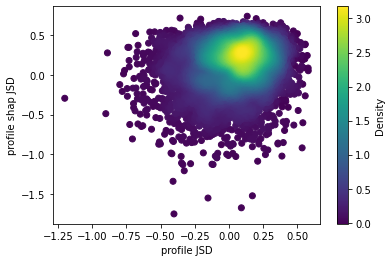

In [26]:
density_scatter(np.array(normed_prof), np.array(normed_prof_shap), "profile JSD", "profile shap JSD", ax = None, sort = True, bins = 20,xlim=(0,1),ylim=(0,1))

<AxesSubplot:xlabel='profile JSD', ylabel='count shap JSD'>

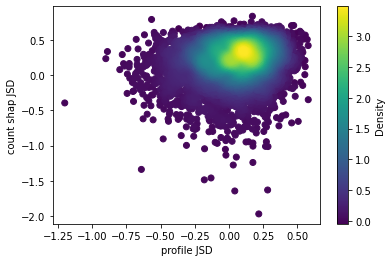

In [27]:
density_scatter(np.array(normed_prof), np.array(normed_counr_shap), "profile JSD", "count shap JSD", ax = None, sort = True, bins = 20,xlim=(0,1),ylim=(0,1))

In [28]:
def make_plots(region, tf_data, sig_data):
    
    midpoint1=tf_data["count_shap"][region].shape[0]//2
    midpoint2=sig_data["count_shap"][region].shape[0]//2

    mid1 = tf_data["label_prof"][region].shape[0]//2
    mid2 = sig_data["label_prof"][region].shape[0]//2

    tf_prof = tf_data["label_prof"][region][mid1-500: mid1+500]
    sig_prof = sig_data["label_prof"][region][mid2-500:mid2+500]
    
    tf_prof = scipy.ndimage.gaussian_filter1d(tf_prof, 7, truncate=(80 / 14))
    sig_prof = scipy.ndimage.gaussian_filter1d(sig_prof, 7, truncate=(80 / 14))
    
    
    x1 = np.abs(np.sum(tf_data["count_shap"][region]*tf_data["seq"][region],axis=1))[midpoint1-500:midpoint1+500]+1e-2
    x2 = np.abs(sig_data["count_shap"][region])[midpoint2-500:midpoint2+500]+1e-2
   
    x1 = scipy.ndimage.gaussian_filter1d(x1, 7, truncate=(80 / 14))
    x2 = scipy.ndimage.gaussian_filter1d(x2, 7, truncate=(80 / 14))
    
    print("JSD profile",jensenshannon(tf_prof, sig_prof, 2.0))
    print("Count shap JSD",jensenshannon( x1, x2, 2.0))
    print("Profile shap JSD",jensenshannon( np.abs(np.sum(tf_data["profile_shap"][region]*tf_data["seq"][region],axis=1))[midpoint1-500:midpoint1+500]+1e-2, np.abs(sig_data["profile_shap"][region])[midpoint2-500:midpoint2+500]+1e-2, 2.0))
  
    plt.figure(figsize=(20.2, 2.0))
    plt.plot(x1,label="tf")
    plt.plot(x2, label="H3K27Ac")
    plt.legend()
    plt.show()
    
        
    plt.figure(figsize=(20.2, 2.0))
    plt.plot(scipy.ndimage.gaussian_filter1d(tf_data["label_prof"][region], 7, truncate=(80 / 14)), label="SPI1 TF profile")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20.2, 2.0))
    plt.plot(scipy.ndimage.gaussian_filter1d(sig_data["label_prof"][region], 7, truncate=(80 / 14)), label="H3K27Ac profile")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20.2, 2.0))
    plt.plot(tf_prof, label="SPI1 TF profile")
    plt.plot(sig_prof, label="H3K27Ac profile")
    plt.legend()
    plt.show()
    
    
    print("SPI1 Count Shap")
    act_scores = tf_data["count_shap"][region]*tf_data["seq"][region]
    #print(act_scores)
    input_length_sig = act_scores.shape[0]
    viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - 500:(input_length_sig // 2) + 500], subticks_frequency=100)
    
    print("SPI1 Profile Shap")
    act_scores = tf_data["profile_shap"][region]*tf_data["seq"][region]
    input_length_sig = act_scores.shape[0]
    viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - 500:(input_length_sig // 2) + 500], subticks_frequency=100)
    
    
    print("H3K27Ac Count Shap")
    act_scores = (np.tile(np.reshape(sig_data["count_shap"][region],(5000,1)),(1,4)))*sig_data["seq"][region]
    input_length_sig = act_scores.shape[0]
    viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - 500:(input_length_sig // 2) + 500], subticks_frequency=100)
    
    print("H3K27Ac Profile Shap")
    act_scores = (np.tile(np.reshape(sig_data["profile_shap"][region],(5000,1)),(1,4)))*sig_data["seq"][region]
    input_length_sig = act_scores.shape[0]
    viz_sequence.plot_weights(act_scores[(input_length_sig // 2) - 500:(input_length_sig // 2) + 500], subticks_frequency=100)

In [29]:
#print(np.array(normed_prof_shap)[ np.array(normed_counr_shap)>=0.5])

In [30]:
cond1 = np.array(normed_prof)<=0.01
cond2 = np.logical_and(np.array(normed_counr_shap)>=0.6,np.array(normed_prof_shap)>=0.6)
idxc = 0
regions = np.logical_and(cond1, cond2)
intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

6
['chr5' '136310130']
normed JSD of profile -0.07738032251459104
normed JSD of profile shap 0.6697312076002568
normed JSD of count shap 0.6547129784412196
JSD profile 0.5868202472742664


ValueError: operands could not be broadcast together with shapes (1000,) (1000,4) 

In [ ]:
cond1 = np.array(normed_prof)<=0.01
cond2 = np.logical_and(np.array(normed_counr_shap)>=0.6,np.array(normed_prof_shap)>=0.6)
idxc = 1
regions = np.logical_and(cond1, cond2)
intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.array(normed_prof)<=0.01
cond2 = np.logical_and(np.array(normed_counr_shap)>=0.6,np.array(normed_prof_shap)>=0.6)
idxc = 15
regions = np.logical_and(cond1, cond2)
intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.array(normed_prof)>=0.3
cond2 = np.logical_and(np.array(normed_counr_shap)>=0.3,np.array(normed_prof_shap)>=0.3)
idxc = 0
regions = np.logical_and(cond1, cond2)
intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.array(normed_prof)>0.15
cond2 = np.logical_and(np.array(normed_counr_shap)<0.01,np.array(normed_prof_shap)<0.01)
idxc = 0
regions = np.logical_and(cond1, cond2)
intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.array(normed_prof)<=0.01
cond2 = np.logical_and(np.array(normed_counr_shap)<=0.01,np.array(normed_prof_shap)<=0.01)
idxc = 0
regions = np.logical_and(cond1, cond2)
intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.array(normed_prof)<=0.01
cond2 = np.logical_and(np.array(normed_counr_shap)<=0.01,np.array(normed_prof_shap)<=0.01)
idxc = 1
regions = np.logical_and(cond1, cond2)
intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.logical_and(np.array(normed_prof)>-0.2,np.array(normed_prof)<0.05)
cond2 = np.logical_and(np.array(normed_counr_shap)>0.35,np.array(normed_counr_shap)<0.65)
cond3 = np.logical_and(np.array(normed_prof_shap)>0.35,np.array(normed_prof_shap)<0.60)

idxc = 10
regions = np.logical_and(cond1, cond2)
regions = np.logical_and(regions, cond3)

intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.logical_and(np.array(normed_prof)>-0.2,np.array(normed_prof)<0.05)
cond2 = np.logical_and(np.array(normed_counr_shap)>0.35,np.array(normed_counr_shap)<0.65)
cond3 = np.logical_and(np.array(normed_prof_shap)>0.35,np.array(normed_prof_shap)<0.60)

idxc = 0
regions = np.logical_and(cond1, cond2)
regions = np.logical_and(regions, cond3)

intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.logical_and(np.array(normed_prof)>-0.2,np.array(normed_prof)<0.05)
cond2 = np.logical_and(np.array(normed_counr_shap)>0.35,np.array(normed_counr_shap)<0.65)
cond3 = np.logical_and(np.array(normed_prof_shap)>0.35,np.array(normed_prof_shap)<0.60)

idxc = 100
regions = np.logical_and(cond1, cond2)
regions = np.logical_and(regions, cond3)

intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.logical_and(np.array(normed_prof)>-0.2,np.array(normed_prof)<0.05)
cond2 = np.logical_and(np.array(normed_counr_shap)>0.35,np.array(normed_counr_shap)<0.65)
cond3 = np.logical_and(np.array(normed_prof_shap)>0.35,np.array(normed_prof_shap)<0.60)

idxc = 60
regions = np.logical_and(cond1, cond2)
regions = np.logical_and(regions, cond3)

intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)

In [ ]:
cond1 = np.logical_and(np.array(normed_prof)>-0.2,np.array(normed_prof)<0.05)
cond2 = np.logical_and(np.array(normed_counr_shap)>0.35,np.array(normed_counr_shap)<0.65)
cond3 = np.logical_and(np.array(normed_prof_shap)>0.35,np.array(normed_prof_shap)<0.60)

idxc = 1000
regions = np.logical_and(cond1, cond2)
regions = np.logical_and(regions, cond3)

intersections=np.array(list(input_key_list))[regions]
print(len(intersections))
print(intersections[idxc])
print("normed JSD of profile", np.array(normed_prof)[regions][idxc])
print("normed JSD of profile shap", np.array(normed_prof_shap)[regions][idxc])
print("normed JSD of count shap", np.array(normed_counr_shap)[regions][idxc])
make_plots((intersections[idxc][0], int(intersections[idxc][1])), tf_data, sig_data)